## This is the first notebook done after the hackathon
### I'm using a different approach to calculating features (more array and vector based and less row and loop based) which is speeding up the calculation. 
### The thought process is the same
#### - Justin

In [3]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import welly
from welly import Well
import lasio
import glob
from sklearn import neighbors
import pickle
import math
welly.__version__

'0.3.0'

In [4]:
%%timeit
import os
env = %env


98.9 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [5]:
from IPython.display import display

In [6]:
#### Test results Part 1
#### Had to change display options to get this to print in full!
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100000

## We're going to load a pickle file of a previously created dataframe

### The dataframe merges:
1. picks_dic = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
2. picks = pd.read_csv('../../SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
3. wells = pd.read_csv('../../SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
4. gis = pd.read_csv('../../well_lat_lng.csv')

### It also excludes any wells that have nulls or zeros for Top McMurray or Base McMurray picks
This was done in notebooks: 
1. notebooks_2018/mapmaking/Map_Exploration_v2-KDtree.ipynb
2. notebooks_2018/Test_RUN_2018_02/DataCleaningPrepof_KNN_neighborPickDepth_df_creation_vA_20180210

### Let's load in the pickle file of the dataframe from previous notebook mentioned above

In [7]:
wells_df_new_cleaned_plus_nn_wNoNulls =  pd.read_pickle('wells_df_new_cleaned_plus_nn_wNoNulls.p')

In [8]:
wells_df_new_cleaned_plus_nn_wNoNulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1921 entries, 0 to 2192
Data columns (total 16 columns):
SitID                                  1921 non-null int64
McMurray_Base_HorID                    1921 non-null int64
McMurray_Top_HorID                     1921 non-null int64
McMurray_Base_DEPTH                    1921 non-null float64
McMurray_Top_DEPTH                     1921 non-null float64
McMurray_Base_Qual                     1921 non-null int64
McMurray_Top_Qual                      1921 non-null int64
lat                                    1921 non-null float64
lng                                    1921 non-null float64
UWI                                    1921 non-null object
Neighbors_Obj                          1921 non-null object
NN1_McMurray_Top_DEPTH                 1921 non-null float64
NN1_McMurray_Base_DEPTH                1921 non-null float64
NN1_thickness                          1921 non-null float64
MM_Top_Depth_predBy_NN1thick           1921 non-nul

In [9]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0     [{'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899, 'neighbor': 1}, {'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858, 'neighbor': 2}, {'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222, 'neighbor': 3}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123, 'neighbor': 4}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244, 'neighbor': 5}, {'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076, 'neighbor': 6}, {'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453, 'neighbor': 7}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355, 'neighbor': 2}, {'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727, 'neighbor': 3}, {'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476, 'neighbor': 4}, {'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782, 'neighbor': 5}, {'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062, 'neighbor': 6}, {'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145, 'neighbor': 7}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0    [{'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428, 'neighbor': 2}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782, 'neighbor': 3}, {'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212, 'neighbor': 4}, {'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036, 'neighbor': 5}, {'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113, 'neighbor': 6}, {'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725, 'neighbor': 7}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715, 'neighbor': 2}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529, 'neighbor': 3}, {'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945, 'neighbor': 4}, {'UWI': '00/06-13-068-03W

In [10]:
print(len(wells_df_new_cleaned_plus_nn_wNoNulls))

1921


In [11]:
wells_df_new_cleaned_plus_nn_wNoNulls.head()

SitID  McMurray_Base_HorID  McMurray_Top_HorID  McMurray_Base_DEPTH  McMurray_Top_DEPTH  McMurray_Base_Qual  McMurray_Top_Qual        lat         lng                  UWI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Neighbors_Obj  NN1_McMurray_Top_DEPTH  NN1_McMurray_Base_DEPTH  NN1_thickness  MM_Top_Depth_predBy_NN1thick  MM_Top_Depth_Real_v_predBy_NN1thick
0  102496                14000               13000                561.0               475.0                   1                  3  54.785907 -110.129320  00/12-08-067-01W4/0     [{'UWI': '00/09-11-067-02W4/0', 'distance': 0.05753100195547899, 'neighbor': 1}, {'UWI': '00/11-08-068-01W4/0', 'distance': 0.08749430324884858, 'neighbor': 2}, {'UWI': '00/09-11-068-02W4/0', 'distance': 0.10451669032744222, 'neighbor': 3}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.1099989647224123, 'neighbor': 4}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.14017282905400244, 'neighbor': 5}, {'UWI': '00/06-26-068-02W4/0', 'distance': 0.14539497462086076, 'neighbor': 6}, {'UWI': '00/10-29-067-02W4/0', 'distance': 0.14676425482044453, 'neighbor': 7}]                   544.0                    630.0           86.0                         475.0                                  0.0
1  102497                14000               13000                604.5               515.0                   1                  3  54.782284 -110.269446  00/07-08-067-02W4/0    [{'UWI': '00/10-29-067-02W4/0', 'distance': 0.04734000608365529, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.07332213830078355, 'neighbor': 2}, {'UWI': '00/07-36-067-03W4/0', 'distance': 0.07725585850924727, 'neighbor': 3}, {'UWI': '00/10-14-067-03W4/0', 'distance': 0.07846755926496476, 'neighbor': 4}, {'UWI': '00/09-11-067-02W4/0', 'distance': 0.08267376663125782, 'neighbor': 5}, {'UWI': '00/10-08-068-02W4/0', 'distance': 0.09089701215112062, 'neighbor': 6}, {'UWI': '00/06-13-068-03W4/0', 'distance': 0.11681159403073145, 'neighbor': 7}]                   529.0                    613.0           84.0                         520.5                                 -5.5
2  102498                14000               13000                564.0               480.0                   1                  3  54.785892 -110.186851  00/09-11-067-02W4/0    [{'UWI': '00/12-08-067-01W4/0', 'distance': 0.05753100195547899, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.06649378619088428, 'neighbor': 2}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.08267376663125782, 'neighbor': 3}, {'UWI': '00/09-11-068-02W4/0', 'distance': 0.08728400165551212, 'neighbor': 4}, {'UWI': '00/10-29-067-02W4/0', 'distance': 0.09343691917544036, 'neighbor': 5}, {'UWI': '00/11-08-068-01W4/0', 'distance': 0.10808166919974113, 'neighbor': 6}, {'UWI': '00/10-08-068-02W4/0', 'distance': 0.12013967631468725, 'neighbor': 7}]                   529.0                    613.0           84.0                         480.0                                  0.0
3  102500                14000               13000                636.5               549.0                   1                  3  54.829624 -110.269422  00/10-29-067-02W4/0   [{'UWI': '00/10-08-068-02W4/0', 'distance': 0.04355700607250212, 'neighbor': 1}, {'UWI': '00/06-34-067-02W4/0', 'distance': 0.04589036401030715, 'neighbor': 2}, {'UWI': '00/07-08-067-02W4/0', 'distance': 0.04734000608365529, 'neighbor': 3}, {'UWI': '00/07-36-067-03W4/0', 'distance': 0.052016152587450945, 'neighbor': 4}, {'UWI': '00/06-13-068-03W

In [12]:
df_new = wells_df_new_cleaned_plus_nn_wNoNulls
# df_new["UWI (AGS)"] = df_new["UWI (AGS)_x"]
df_new["UWI"] = df_new["UWI"]
df_new["HorID"] = df_new["McMurray_Top_HorID"]
df_new["Pick"] = df_new["McMurray_Top_DEPTH"]
df_new["Quality"] = df_new["McMurray_Top_Qual"]
df_new["HorID_paleoz"] = df_new["McMurray_Base_HorID"]
df_new["Pick_paleoz"] = df_new["McMurray_Base_DEPTH"]
df_new["Quality_paleoz"] = df_new["McMurray_Base_Qual"]
df_new = df_new[["SitID","UWI","HorID","Pick","Quality","HorID_paleoz","Pick_paleoz","Quality_paleoz",'lat','lng','MM_Top_Depth_predBy_NN1thick','NN1_thickness']]
df_new

SitID                  UWI  HorID    Pick  Quality  HorID_paleoz  Pick_paleoz  Quality_paleoz        lat         lng  MM_Top_Depth_predBy_NN1thick  NN1_thickness
0     102496  00/12-08-067-01W4/0  13000  475.00        3         14000       561.00               1  54.785907 -110.129320                        475.00          86.00
1     102497  00/07-08-067-02W4/0  13000  515.00        3         14000       604.50               1  54.782284 -110.269446                        520.50          84.00
2     102498  00/09-11-067-02W4/0  13000  480.00        3         14000       564.00               1  54.785892 -110.186851                        480.00          84.00
3     102500  00/10-29-067-02W4/0  13000  549.00        3         14000       636.50               1  54.829624 -110.269422                        552.50          84.00
4     102501  00/06-34-067-02W4/0  13000  529.00        2         14000       613.00               1  54.840471 -110.224832                        524.00          89.00
5     102503  00/11-04-067-03W4/0  13000  488.50        2         14000       553.50               1  54.771449 -110.402983                        489.00          64.50
6     102505  00/10-08-067-03W4/0  13000  501.50        2         14000       572.50               1  54.785901 -110.422131                        508.00          64.50
7     102507  00/10-14-067-03W4/0  13000  553.50        2         14000       606.50               1  54.800533 -110.345762                        542.00          64.50
8     102514  00/10-28-067-03W4/0  13000  493.50        3         14000       558.00               1  54.829633 -110.396621                        487.00          71.00
9     102517  00/07-36-067-03W4/0  13000  536.50        2         14000       615.00               1  54.840441 -110.320301                        562.00          53.00
10    102518  00/10-02-067-04W4/0  13000  528.00        1         14000       588.50               1  54.771451 -110.498414                        517.50          71.00
11    102565  00/10-07-067-04W4/0  13000  514.00        1         14000       568.50               1  54.785896 -110.599928                        507.50          61.00
12    102577  00/11-24-067-04W4/0  13000  487.50        1         14000       552.00               1  54.814989 -110.479147                        486.00          66.00
13    102581  00/07-33-067-04W4/0  13000  509.00        1         14000       570.00               1  54.840482 -110.549109                        504.00          66.00
14    102583  00/13-03-067-05W4/0  13000  487.00        2         14000       543.50               1  54.775090 -110.688675                        491.00          52.50
15    102589  00/06-16-067-05W4/0  13000  486.00        1         14000       540.00               1  54.796954 -110.707896                        487.50          52.50
16    102592  00/07-25-067-05W4/0  13000  490.50        1         14000       557.50               1  54.826012 -110.625318                        503.00          54.50
17    102596  00/10-33-067-05W4/0  13000  481.00        1         14000       533.50               1  54.844116 -110.701599                        473.00          60.50
18    102597  00/15-01-067-06W4/0  13000  503.00        2         14000       531.50               1  54.775087 -110.777910                        477.50          54.00
19    102606  00/06-17-067-06W4/0  13000  492.00        3         14000       533.00               1  54.796947 -110.885862                        482.00          51.00
20    141727  00/07-23-067-06W4/0  13000  484.00        2         14000       534.50               1  54.811402 -110.803309                        479.00          55.50
21    102609  00/02-29-067-06W4/0  13000  493.00        2         14000       543.00               1  54.822471 -110.879581                        495.00          48.00
22    102610  00/11-05-067-07W4/0  13000  473.00        1         14000       537.00               1  54.771468 -111.038

In [13]:
print(len(df_new))

1921


In [14]:
#### Number of unique wells based on UWI
len(df_new.UWI.unique())

1921

In [15]:
df_new_test = df_new[['UWI']]

In [16]:
print(any(df_new_test.UWI == '00/11-04-067-03W4/0'))

True


## Brainstorm 1 : various features to extract
1. Find average values of [each curve] in [different] length windows [above, around, below] a depth
2. Find average for [different number of] [max, min] values in [different] length windows [above, around, below] a depth for [each curve]
3. Find gradient within [window length] around a depth point 
4. Find [min, avg, max] gradient of various [smaller window length] within a larger [larger window length]
5. Find number of gradient changes (negative to positive) of various [smaller window length] within a larger [larger window length]
6. Find difference between two windows on either side of a given depth. For each window, average for [different number of] [max, min] values in [different] length windows above & below a given depth for [each curve].

In [17]:
####
def addColWindowMean(df,col,windowSize,centered):
    featureName = col+"_mean_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).mean() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [18]:
####
def addColWindowMax(df,col,windowSize,centered):
    featureName = col+"_max_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).max() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).max() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [19]:
#### Returns a column with the min values of a window centered 
def addColWindowMin(df,col,windowSize,centered):
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered
    if(centered == "around"):
        df[featureName] = df[col].rolling(center=True,window=windowSize).min() 
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        df[featureName] = df[col].rolling(center=False,window=windowSize).min() 
        #### unreverse
        
        df = df.sort_index(ascending=True)
    return df

In [20]:
#### helper function that takes in array and an integer for the number of highest values to find the mean of 
#### example: for an array = [1,3,6,44,33,22,452] and nValues = 2, the answer would be 44+452 / 2
def nLargest(array,nValues):
    answer = np.mean(array[np.argsort(array)[-nValues:]])  
    return answer

In [70]:
#### Returns a column with the average of the N largest values of a window 
def addColWindowAvgMaxNvalues(df,col,windowSize,centered,nValues):
    #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
    #return df
    featureName = col+"_min_"+str(windowSize)+"winSize_"+"dir"+centered+"_n"+str(nValues)
    if(centered == "around"):
        #df[featureName] = df[col].rolling(center=True,window=windowSize).nlargest(nValues).mean() 
        df[featureName] = df[col].rolling(center=True,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "above"):
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
    elif(centered == "below"):
        #### reverse data frame
        #df = df.iloc[::-1]
        df = df.sort_index(ascending=False)
        #   # df['new_column'] = df.apply(lambda x: your_function(x['High'],x['Low'],x['Close']), axis=1)
        df[featureName] = df[col].rolling(center=False,window=windowSize).apply(lambda x: nLargest(x,nValues))
        #df[featureName] = df[col].rolling(center=False,window=windowSize).nlargest(nValues).mean() 
        #### unreverse
        df = df.sort_index(ascending=True)
    return df

In [120]:
#### Seeks to determine degree of change in gamma-ray curve value -1 meters below each point in the well
#### Often the top of McMurray is an increase of shale
#### Initially this will return a value... which could be positive or negative. 
#### Eventually it might need to be a one hot value and multiple feautres?
#### df = dataframe, curve_name could be GR, direction is shift positive or negative direction, 
#### shiftSize is size of shift like - 1 
def IsBelowLowerGr(df,curve_name,direction,shiftSize):
    shift = shiftSize*direction
    if direction == -1:
        directString = "Neg"
    else:
        directString = "Pos"
    shiftName = curve_name+"_Shift"+directString+shiftSize
    shiftNameValue = shiftName+"_Val"
    shiftNameBol = shiftName+"_Bool"
    
    df[shiftName] = df[curve_name].shift(shift)
    df[shiftNameValue] = df[curve_name] - df[shiftName]
    df[shiftNameBol] = df[curve_name] > df[shiftName]
    
    
    return df

In [78]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns value
def NN1_TopMcMDepth(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth'] = df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'] 
    return df


In [79]:
#### Takes MM_Top_Depth_predBy_NN1thick and subtracts depth at that point, returns *absolute* value
def NN1_TopMcMDepth_Abs(df,MM_Top_Depth_predBy_NN1thick):
    df['DistFrom_NN1_TopDepth_Abs'] = math.fabs(df[MM_Top_Depth_predBy_NN1thick] - df['DEPT'])
    return df

In [80]:
####
winVars = {"RangeOfCurves":['GR'],
                   "RangeOfWindows":[5,11,29],
                   "RangeOfWindowsCaution":[5],
                   "RangeOfDirection":['above','below','around'],
                   "MinOrMaxRange":['min','max'],
                   "NumbPtsRange":[1,5]}

## Read in well logs from LAS files and put into Dictionary of Dataframes. As Reading-in, add features

In [121]:
def loadAndAddFeatures():
    count=0
    data_df=[]
    count_limit =1663
    list_of_failed_wells = []
    ### dictionary that holds every well as key:value or "UWI":df pair
    df_w_dict ={}
    while count < count_limit:
        for file in glob.glob('../../SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
            #### NOTE: limiting wells being read-in to 101 here !!!!!!!!!!!!!!!!
            count+=1
            if count > count_limit:
                print("hit limit of count below file for loop")
                answer = [df_w_dict,list_of_failed_wells]
                return answer
            else:
                l_df = lasio.read(file).df()
                #print(l_df)
                str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
                #l_df.DEPT = l_df.DEPT.astype(float)
                ##bottom_well_depth = l_df['DEPT'].max()
                if any(df_new.UWI == str_uwi):
                    if df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0] > -1:
                        l_df = l_df.reset_index()
                        print("got to UWI apppend")
                        l_df['UWI'] = str_uwi
                        print("UWI added is ",str_uwi," and type is ",type(str_uwi))
                        l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
#                         l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
                        l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
                        l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
                        l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]
                        #### adding in paleozoic surface pick
                        l_df['Pick_paleoz']=df_new[df_new['UWI']==str_uwi]['Pick_paleoz'].iloc[0] 
                        l_df['HorID_paleoz']=df_new[df_new['UWI']==str_uwi]['HorID_paleoz'].iloc[0]
                        l_df['Quality_paleoz']=df_new[df_new['UWI']==str_uwi]['Quality_paleoz'].iloc[0]
                        
                        #### new as of 2018-02
                        l_df['MM_Top_Depth_predBy_NN1thick']=df_new[df_new['UWI']==str_uwi]['MM_Top_Depth_predBy_NN1thick'].iloc[0]
                        l_df['NN1_thickness']=df_new[df_new['UWI']==str_uwi]['NN1_thickness'].iloc[0]

                        print("got to end of col append & pick is ",l_df.Pick.unique()[0])  
                        try:
                            print("in first try statement, count = ",count)
                            float(l_df.Pick.unique()[0])
                            l_df.Pick = l_df.Pick.astype(float)
                            l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick']=l_df['Pick']-l_df['DEPT']
#                             l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
                            l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 0 if x==0 else ( 10 if (x !=0 and -3 < x and x <3) else 100))
#                             lambda x: x*10 if x<2 else (x**2 if x<4 else x+10)
                            #### doing the same as below but for BASE mcMurray or Paleozoic surface pick
                            float(l_df.Pick_paleoz.unique()[0])
                            l_df.Pick_paleoz = l_df.Pick_paleoz.astype(float)
                            #l_df.DEPT = l_df.DEPT.astype(float)
                            l_df['new_pick_paleoz']=l_df['Pick_paleoz']-l_df['DEPT']
                            l_df['new_pick2_paleoz']=l_df['new_pick_paleoz'].apply(lambda x: 1 if(x==0) else 0)
                            
                            #### new as of 2018-02
                            try:
                                l_df_new = NN1_TopMcMDepth(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            try:
                                l_df_new = NN1_TopMcMDepth_Abs(l_df,'MM_Top_Depth_predBy_NN1thick')
                            except:
                                    pass
                            
                            print("got to below astype part")
                            #### instead of concat into a single dataframe, run functions & then add to dictionary   
                            ##### run functions to create features on array basis for each well in separate dataframe
                            ##### this makes certain things easier, compared to everything in a single dataframe, like making sure you don't accidentally grab data from next well up
                            ##### and will make it easier to write data back to LAS if we run into memory limitations later
                            curves = ['GR','ILD']
                            windows = [1,3,7,15,21]
                            directions = ["around","below","above"]
                            comboArg_A = [curves,windows,directions]
                            all_comboArgs_A = list(itertools.product(*comboArg_A))
                            for eachArgList in all_comboArgs_A:
                                try:
                                    l_df_new = addColWindowMean(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMax(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowMin(l_df,eachArgList[0],eachArgList[1],eachArgList[2])
                                except:
                                    pass
                                try:
                                    l_df_new = addColWindowAvgMaxNvalues(l_df,eachArgList[0],eachArgList[1],eachArgList[2],3)
                                except:
                                    pass
                            #### add resultant dataframe to dictionary
                            step = [1,2]
                            direction = [1,-1]
                            curves2 = ['GR','ILD']
#                             comboArg_B = [curves2,direction,step]
#                             all_comboArgs_B = list(itertools.product(*comboArg_B))
#                             for eachArgList in all_comboArgs_B:
#                                 try:
# #                                     IsBelowLowerGr(df,curve_name,direction,shiftSize)
# #                                         l_df_new = IsBelowLowerGr(df,"GR",-1,1)
#                                      l_df_new = IsBelowLowerGr(df,eachArgList[0],eachArgList[1],eachArgList[2])
#                                 except:
#                                     pass
                             
                            try:
                                l_df_new = IsBelowLowerGr(df,"GR",-1,1)
                            except:
                                print("couldn't do step function")
                            if l_df['DEPT'].max() < 600:
                                df_w_dict[l_df_new['UWI'][0]]= l_df_new
                        except ValueError as e:
                            print("e = ",e)
                            print ('Error picking')
                            template = "An exception of type {0} occurred. Arguments:\n{1!r}"
                            message = template.format(type(e).__name__, e.args)
                            print("message = ",message)
                            print("file = ",file)
                            print("Got except, UWI added is ",str_uwi," and type is ",type(str_uwi))
                            list_of_failed_wells.append(str_uwi)
                            #continue;
                    else:
                        pass
                else:
                    pass
            #print("result = ",df_w_dict)
    #else: 
    #    return df_w_dict, list_of_failed_wells
    answer = [df_w_dict,list_of_failed_wells]
    
    return answer

In [122]:
## %timeit
answer = loadAndAddFeatures()

got to UWI apppend
UWI added is  00/01-01-073-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  607.0
in first try statement, count =  1
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/01-03-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  243.0
in first try statement, count =  3
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/01-04-075-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  631.0
in first try statement, count =  4
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/01-05-085-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  253.0
in first try statement, count =  5
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/01-08-080-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  6
got to

couldn't do step function
got to UWI apppend
UWI added is  00/03-02-084-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  283.0
in first try statement, count =  49
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/03-03-081-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  422.0
in first try statement, count =  50
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/03-04-072-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  471.0
in first try statement, count =  51
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/03-05-075-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  642.0
in first try statement, count =  52
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/03-06-067-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  531.0
in first tr

couldn't do step function
got to UWI apppend
UWI added is  00/04-12-081-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  437.0
in first try statement, count =  97
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/04-13-077-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  336.0
in first try statement, count =  98
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/04-15-081-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  424.28
in first try statement, count =  99
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/04-19-083-23W4/0  and type is  <class 'str'>
got to end of col append & pick is  408.43
in first try statement, count =  101
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/04-20-084-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  253.0
in first

couldn't do step function
got to UWI apppend
UWI added is  00/05-19-070-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.0
in first try statement, count =  149
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/05-19-077-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  320.5
in first try statement, count =  150
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/05-19-078-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  429.16
in first try statement, count =  151
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/05-19-079-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  264.0
in first try statement, count =  152
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/05-20-070-05W5/0  and type is  <class 'str'>
got to end of col append & pick is  852.0
in fir

couldn't do step function
got to UWI apppend
UWI added is  00/06-03-074-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  462.08
in first try statement, count =  195
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-03-075-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  470.0
in first try statement, count =  196
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-03-077-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  373.0
in first try statement, count =  197
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-03-077-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  634.59
in first try statement, count =  198
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-03-078-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  427.94
in f

couldn't do step function
got to UWI apppend
UWI added is  00/06-08-084-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  174.0
in first try statement, count =  240
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-09-068-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  497.5
in first try statement, count =  242
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-09-072-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  481.0
in first try statement, count =  243
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-09-073-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  491.0
in first try statement, count =  244
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-09-074-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  401.0
in firs

couldn't do step function
got to UWI apppend
UWI added is  00/06-15-080-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  416.0
in first try statement, count =  286
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-16-067-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  486.0
in first try statement, count =  287
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-16-070-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  428.0
in first try statement, count =  288
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-16-077-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  315.16
in first try statement, count =  289
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-16-079-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  360.88
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/06-22-072-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  430.99
in first try statement, count =  327
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-22-075-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  459.64
in first try statement, count =  328
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-22-078-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  310.0
in first try statement, count =  329
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-22-082-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.0
in first try statement, count =  330
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-23-068-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  453.0
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/06-27-068-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  486.16
in first try statement, count =  371
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-27-071-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  459.0
in first try statement, count =  372
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-27-082-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  318.21
in first try statement, count =  373
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-27-083-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  457.81
in first try statement, count =  374
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-27-083-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  298.7
in f

couldn't do step function
got to UWI apppend
UWI added is  00/06-32-082-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  273.1
in first try statement, count =  417
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-33-070-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  448.0
in first try statement, count =  418
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-33-070-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  580.03
in first try statement, count =  420
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-33-074-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.81
in first try statement, count =  421
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/06-33-074-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  760.78
in f

couldn't do step function
got to UWI apppend
UWI added is  00/06-36-095-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  298.0
in first try statement, count =  462
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-01-068-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  492.0
in first try statement, count =  463
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-01-070-27W4/0  and type is  <class 'str'>
got to end of col append & pick is  690.07
in first try statement, count =  464
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-01-074-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  650.0
in first try statement, count =  465
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-01-077-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  690.68
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/07-08-076-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  516.33
in first try statement, count =  510
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-08-076-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  555.0
in first try statement, count =  511
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-08-081-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  253.59
in first try statement, count =  512
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-08-081-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  353.57
in first try statement, count =  513
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-08-082-07W4/0  and type is  <class 'str'>
got to end of col append & pick is  470.61
in 

couldn't do step function
got to UWI apppend
UWI added is  00/07-14-070-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.27
in first try statement, count =  551
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-14-078-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  448.06
in first try statement, count =  552
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-14-079-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  515.11
in first try statement, count =  553
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-14-083-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  295.0
in first try statement, count =  554
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-14-091-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  235.0
in f

couldn't do step function
got to UWI apppend
UWI added is  00/07-20-079-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  252.0
in first try statement, count =  597
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-20-081-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  425.0
in first try statement, count =  598
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-20-084-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  403.5
in first try statement, count =  599
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-21-069-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  457.2
in first try statement, count =  600
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-21-073-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  588.26
in fir

couldn't do step function
got to UWI apppend
UWI added is  00/07-26-075-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  582.78
in first try statement, count =  643
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-26-076-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  461.47
in first try statement, count =  644
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-26-079-10W4/0  and type is  <class 'str'>
got to end of col append & pick is  423.06
in first try statement, count =  645
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-26-079-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  449.58
in first try statement, count =  646
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-26-080-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  487.0
in 

couldn't do step function
got to UWI apppend
UWI added is  00/07-33-073-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.0
in first try statement, count =  693
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-33-073-20W4/0  and type is  <class 'str'>
got to end of col append & pick is  598.63
in first try statement, count =  694
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-33-074-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  456.29
in first try statement, count =  695
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-33-074-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  602.0
in first try statement, count =  696
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/07-33-076-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  532.0
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/08-05-073-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  589.0
in first try statement, count =  737
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/08-05-075-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  619.35
in first try statement, count =  738
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/08-05-086-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  355.09
in first try statement, count =  739
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/08-06-078-19W4/0  and type is  <class 'str'>
got to end of col append & pick is  400.0
in first try statement, count =  740
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/08-07-095-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  308.46
in f

couldn't do step function
got to UWI apppend
UWI added is  00/09-13-072-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0
in first try statement, count =  786
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/09-13-083-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  232.0
in first try statement, count =  787
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/09-14-071-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.0
in first try statement, count =  788
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/09-14-081-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  392.5
in first try statement, count =  789
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/09-17-073-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  467.0
in firs

couldn't do step function
got to UWI apppend
UWI added is  00/10-02-070-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  443.0
in first try statement, count =  830
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-02-070-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  619.96
in first try statement, count =  831
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-02-074-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  411.0
in first try statement, count =  832
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-02-077-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.0
in first try statement, count =  833
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-02-082-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  198.73
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/10-07-077-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  619.35
in first try statement, count =  876
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-07-081-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.23
in first try statement, count =  877
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-07-093-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  174.5
in first try statement, count =  878
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-08-067-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  501.5
in first try statement, count =  879
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-08-068-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  572.0
in fi

couldn't do step function
got to UWI apppend
UWI added is  00/10-12-074-26W4/0  and type is  <class 'str'>
got to end of col append & pick is  605.03
in first try statement, count =  922
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-12-079-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  300.0
in first try statement, count =  924
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-12-089-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  182.5
in first try statement, count =  925
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-13-070-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  462.0
in first try statement, count =  926
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-13-071-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in fir

couldn't do step function
got to UWI apppend
UWI added is  00/10-17-073-04W5/0  and type is  <class 'str'>
got to end of col append & pick is  569.0
in first try statement, count =  970
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-17-074-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  546.0
in first try statement, count =  972
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-17-084-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  388.32
in first try statement, count =  974
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-18-069-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  420.01
in first try statement, count =  976
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-18-071-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  628.19
in f

couldn't do step function
got to UWI apppend
UWI added is  00/10-22-076-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  828.14
in first try statement, count =  1019
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-22-077-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  333.45
in first try statement, count =  1020
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-22-077-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  457.81
in first try statement, count =  1021
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-22-078-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  468.0
in first try statement, count =  1022
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-22-083-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  449.28

couldn't do step function
got to UWI apppend
UWI added is  00/10-26-081-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  308.0
in first try statement, count =  1065
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-26-081-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  429.77
in first try statement, count =  1066
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-26-091-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  236.0
in first try statement, count =  1067
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-27-068-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  458.42
in first try statement, count =  1068
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-27-069-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  532.0
i

couldn't do step function
got to UWI apppend
UWI added is  00/10-30-067-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  519.99
in first try statement, count =  1106
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-30-069-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  493.47
in first try statement, count =  1107
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-30-071-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  491.0
in first try statement, count =  1108
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-30-075-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  502.0
in first try statement, count =  1109
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-30-076-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  347.0
i

couldn't do step function
got to UWI apppend
UWI added is  00/10-34-067-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  450.49
in first try statement, count =  1146
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-34-069-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  476.0
in first try statement, count =  1147
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-34-069-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  442.0
in first try statement, count =  1148
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-34-072-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  500.0
in first try statement, count =  1151
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/10-34-074-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  649.22
i

couldn't do step function
got to UWI apppend
UWI added is  00/11-04-071-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  476.71
in first try statement, count =  1194
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-04-073-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  498.0
in first try statement, count =  1195
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-04-074-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0
in first try statement, count =  1196
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-04-074-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  579.12
in first try statement, count =  1197
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-04-075-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  420.0
i

couldn't do step function
got to UWI apppend
UWI added is  00/11-08-075-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  441.0
in first try statement, count =  1237
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-08-082-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  199.95
in first try statement, count =  1238
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-09-071-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  438.0
in first try statement, count =  1240
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-09-076-02W4/0  and type is  <class 'str'>
got to end of col append & pick is  444.0
in first try statement, count =  1241
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-09-079-15W4/0  and type is  <class 'str'>
got to end of col append & pick is  405.3
in

couldn't do step function
got to UWI apppend
UWI added is  00/11-13-081-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  425.0
in first try statement, count =  1286
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-14-073-02W5/0  and type is  <class 'str'>
got to end of col append & pick is  595.5
in first try statement, count =  1288
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-14-078-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  338.0
in first try statement, count =  1289
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-14-084-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  371.55
in first try statement, count =  1290
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-14-088-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  280.5
in

couldn't do step function
got to UWI apppend
UWI added is  00/11-20-084-04W4/0  and type is  <class 'str'>
got to end of col append & pick is  177.0
in first try statement, count =  1335
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-21-069-13W4/0  and type is  <class 'str'>
got to end of col append & pick is  441.0
in first try statement, count =  1336
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-21-069-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  475.0
in first try statement, count =  1337
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-21-070-12W4/0  and type is  <class 'str'>
got to end of col append & pick is  428.55
in first try statement, count =  1338
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-21-071-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  623.32
i

couldn't do step function
got to UWI apppend
UWI added is  00/11-26-077-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  477.0
in first try statement, count =  1382
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-26-078-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  496.0
in first try statement, count =  1383
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-26-080-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  341.0
in first try statement, count =  1384
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-26-080-24W4/0  and type is  <class 'str'>
got to end of col append & pick is  433.5
in first try statement, count =  1385
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-27-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  469.0
in 

couldn't do step function
got to UWI apppend
UWI added is  00/11-31-079-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  432.0
in first try statement, count =  1427
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-31-082-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  415.75
in first try statement, count =  1428
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-31-083-09W4/0  and type is  <class 'str'>
got to end of col append & pick is  422.45
in first try statement, count =  1429
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-31-090-17W4/0  and type is  <class 'str'>
got to end of col append & pick is  209.0
in first try statement, count =  1430
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-32-070-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  622.5
i

couldn't do step function
got to UWI apppend
UWI added is  00/11-36-078-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  388.32
in first try statement, count =  1475
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-36-078-22W4/0  and type is  <class 'str'>
got to end of col append & pick is  407.21
in first try statement, count =  1476
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/11-36-088-18W4/0  and type is  <class 'str'>
got to end of col append & pick is  189.0
in first try statement, count =  1477
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-02-070-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  669.95
in first try statement, count =  1479
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-04-072-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  474.0


couldn't do step function
got to UWI apppend
UWI added is  00/12-30-078-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  439.0
in first try statement, count =  1519
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-31-069-08W4/0  and type is  <class 'str'>
got to end of col append & pick is  515.0
in first try statement, count =  1520
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-34-075-14W4/0  and type is  <class 'str'>
got to end of col append & pick is  534.0
in first try statement, count =  1522
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-36-070-16W4/0  and type is  <class 'str'>
got to end of col append & pick is  471.5
in first try statement, count =  1524
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/12-36-072-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  497.0
in 

couldn't do step function
got to UWI apppend
UWI added is  00/14-20-087-21W4/0  and type is  <class 'str'>
got to end of col append & pick is  303.0
in first try statement, count =  1570
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/14-24-085-06W4/0  and type is  <class 'str'>
got to end of col append & pick is  170.0
in first try statement, count =  1572
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/14-25-073-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  463.0
in first try statement, count =  1573
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/14-30-068-11W4/0  and type is  <class 'str'>
got to end of col append & pick is  446.0
in first try statement, count =  1574
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/14-33-076-03W4/0  and type is  <class 'str'>
got to end of col append & pick is  368.0
in 

couldn't do step function
got to UWI apppend
UWI added is  00/16-12-073-25W4/0  and type is  <class 'str'>
got to end of col append & pick is  578.0
in first try statement, count =  1619
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/16-12-076-03W5/0  and type is  <class 'str'>
got to end of col append & pick is  752.0
in first try statement, count =  1620
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/16-13-071-01W4/0  and type is  <class 'str'>
got to end of col append & pick is  529.0
in first try statement, count =  1621
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/16-15-073-01W5/0  and type is  <class 'str'>
got to end of col append & pick is  616.31
in first try statement, count =  1622
got to below astype part
couldn't do step function
got to UWI apppend
UWI added is  00/16-15-080-05W4/0  and type is  <class 'str'>
got to end of col append & pick is  221.5
in

In [123]:
#answer=[df_w_dict,list_of_failed_wells]
df_w_dict = answer[0]
list_of_failed_wells = answer[1]

In [124]:
#### dumping dict of data frame to pickle file
wells_and_features_20180210 = df_w_dict
pickle.dump(wells_and_features_20180210, open( "dict_of_df_wells_and_features_class3_NewFeat_20180211d.p", "wb" ) )

### NOTE: not all well logs were read-in successfully, need to go back and find out why

In [125]:
#print(df_w_dict)

In [126]:
print("list_of_failed_wells",list_of_failed_wells)

list_of_failed_wells []


In [127]:
df_w_dict['00/04-13-077-05W4/0']

DEPT     ILD   DPHI   NPHI       GR                  UWI   SitID   Pick  HorID  Quality  Pick_paleoz  HorID_paleoz  Quality_paleoz  MM_Top_Depth_predBy_NN1thick  NN1_thickness  new_pick  new_pick2  new_pick_paleoz  new_pick2_paleoz  DistFrom_NN1_TopDepth  GR_mean_1winSize_diraround  GR_max_1winSize_diraround  GR_min_1winSize_diraround  GR_min_1winSize_diraround_n3  GR_mean_1winSize_dirabove  GR_max_1winSize_dirabove  GR_min_1winSize_dirabove  GR_min_1winSize_dirabove_n3  GR_mean_3winSize_diraround  GR_max_3winSize_diraround  GR_min_3winSize_diraround  GR_min_3winSize_diraround_n3  GR_mean_3winSize_dirabove  GR_max_3winSize_dirabove  GR_min_3winSize_dirabove  GR_min_3winSize_dirabove_n3  GR_mean_7winSize_diraround  GR_max_7winSize_diraround  GR_min_7winSize_diraround  GR_min_7winSize_diraround_n3  GR_mean_7winSize_dirabove  GR_max_7winSize_dirabove  GR_min_7winSize_dirabove  GR_min_7winSize_dirabove_n3  GR_mean_15winSize_diraround  GR_max_15winSize_diraround  \
0    165.00   2.808  0.280  0.542  104.464  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    171.00        100           245.00                 0                 162.50                     104.464                    104.464                    104.464                       104.464                    104.464                   104.464                   104.464                      104.464                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN   
1    165.25   2.811  0.276  0.536  105.686  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.75        100           244.75                 0                 162.25                     105.686                    105.686                    105.686                       105.686                    105.686                   105.686                   105.686                      105.686                  105.890333                    107.521                    104.464                    105.890333                        NaN                       NaN                       NaN                          NaN                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN   
2    165.50   2.922  0.273  0.533  107.521  00/04-13-077-05W4/0  142544  336.0  13000        1        410.0         14000               3                         327.5           82.5    170.50        100           244.50                 0                 162.00                     107.521                    107.521                    107.521                       107.521                    107.521                   107.521                   107.521                      107.521                  106.103000                    107.521                    105.102                    106.103000                 105.890333                   107.521                   104.464                   105.890333                         NaN                        NaN                        NaN                           NaN                        NaN                       NaN                       NaN                          NaN                          NaN                         NaN   
3    165.75   2.979  0.271  0.530  105.102  00/04-13-077-05W4/0  142544  336.0 

In [128]:
## testing one dataframe of one well in dictionary of all that were successfully read in
df_w_dict['00/01-03-085-15W4/0'].shape

(518, 100)

In [129]:
print(len(df_w_dict))

1109


## Turn dictionary of dataframes into single dataframe

In [130]:
def turnDictofDFtoDF(dict_of_df):
    data_df = pd.DataFrame()
    list_of_df = []
    values = dict_of_df.values()
    for each in values:
        list_of_df.append(each)
    data_df = pd.concat(list_of_df)
    return data_df
        

In [131]:
data_df = turnDictofDFtoDF(df_w_dict)
data_df.shape

(922272, 109)

In [132]:
type(data_df)

pandas.core.frame.DataFrame

In [133]:
#### dumpingdata frame to pickle file
df_wells_and_features_20180210 = data_df
pickle.dump(df_wells_and_features_20180210, open( "df_wells_and_features_class3_NewFeat_20180211d_qual_all.p", "wb" ) )

In [134]:
paleozoic_pick_test = data_df['new_pick_paleoz'][1800:2000]
paleozoic_pick_test

50     137.770
51     137.465
52     137.160
53     136.855
54     136.551
55     136.246
56     135.941
57     135.636
58     135.331
59     135.027
60     134.722
61     134.417
62     134.112
63     133.807
64     133.503
65     133.198
66     132.893
67     132.588
68     132.283
69     131.979
70     131.674
71     131.369
72     131.064
73     130.759
74     130.455
75     130.150
76     129.845
77     129.540
78     129.236
79     128.931
80     128.626
81     128.321
82     128.016
83     127.712
84     127.407
85     127.102
86     126.797
87     126.492
88     126.188
89     125.883
90     125.578
91     125.273
92     124.968
93     124.664
94     124.359
95     124.054
96     123.749
97     123.444
98     123.140
99     122.835
100    122.530
101    122.225
102    121.920
103    121.616
104    121.311
105    121.006
106    120.701
107    120.396
108    120.092
109    119.787
110    119.482
111    119.177
112    118.873
113    118.568
114    118.263
115    117.958
116    117

## Key variables that hold data frame column names

In [135]:
keys = ['ILD','DPHI','GR','NPHI','CALI','COND','DELT','RHOB','PHIN','DT','ILM','SP','SFLU','IL','DEPTH','DEPH','MD']

In [136]:
keys2 = ['ILD','DPHI','GR','NPHI','CALI','RHOB']

Adding deritive features

In [137]:
all_col_names = list(df_w_dict['00/04-13-077-05W4/0'])
all_col_names

['DEPT',
 'ILD',
 'DPHI',
 'NPHI',
 'GR',
 'UWI',
 'SitID',
 'Pick',
 'HorID',
 'Quality',
 'Pick_paleoz',
 'HorID_paleoz',
 'Quality_paleoz',
 'MM_Top_Depth_predBy_NN1thick',
 'NN1_thickness',
 'new_pick',
 'new_pick2',
 'new_pick_paleoz',
 'new_pick2_paleoz',
 'DistFrom_NN1_TopDepth',
 'GR_mean_1winSize_diraround',
 'GR_max_1winSize_diraround',
 'GR_min_1winSize_diraround',
 'GR_min_1winSize_diraround_n3',
 'GR_mean_1winSize_dirabove',
 'GR_max_1winSize_dirabove',
 'GR_min_1winSize_dirabove',
 'GR_min_1winSize_dirabove_n3',
 'GR_mean_3winSize_diraround',
 'GR_max_3winSize_diraround',
 'GR_min_3winSize_diraround',
 'GR_min_3winSize_diraround_n3',
 'GR_mean_3winSize_dirabove',
 'GR_max_3winSize_dirabove',
 'GR_min_3winSize_dirabove',
 'GR_min_3winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7wi

In [138]:
##old
OLDfeatures2 = ['DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
 'new_pick_paleoz',
 'GR_mean_5winSize_diraround',
 'GR_max_5winSize_diraround',
 'GR_min_5winSize_diraround',
 'GR_min_5winSize_diraround_n3',
 'GR_mean_5winSize_dirabove',
 'GR_max_5winSize_dirabove',
 'GR_min_5winSize_dirabove',
 'GR_min_5winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_11winSize_diraround',
 'GR_max_11winSize_diraround',
 'GR_min_11winSize_diraround',
 'GR_min_11winSize_diraround_n3',
 'GR_mean_11winSize_dirabove',
 'GR_max_11winSize_dirabove',
 'GR_min_11winSize_dirabove',
 'GR_min_11winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_5winSize_diraround',
 'ILD_max_5winSize_diraround',
 'ILD_min_5winSize_diraround',
 'ILD_min_5winSize_diraround_n3',
 'ILD_mean_5winSize_dirabove',
 'ILD_max_5winSize_dirabove',
 'ILD_min_5winSize_dirabove',
 'ILD_min_5winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_11winSize_diraround',
 'ILD_max_11winSize_diraround',
 'ILD_min_11winSize_diraround',
 'ILD_min_11winSize_diraround_n3',
 'ILD_mean_11winSize_dirabove',
 'ILD_max_11winSize_dirabove',
 'ILD_min_11winSize_dirabove',
 'ILD_min_11winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

In [139]:
# features2original_old = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
# features2_old = [
#     #'DEPT',
#  'DPHI',
#  'NPHI',
#  'GR',
#  'ILD',
#  'SitID',
#  'new_pick_paleoz',
#  'GR_mean_5winSize_diraround',
#  'GR_max_5winSize_diraround',
#  'GR_min_5winSize_diraround',
#  'GR_min_5winSize_diraround_n3',
#  'GR_mean_5winSize_dirabove',
#  'GR_max_5winSize_dirabove',
#  'GR_min_5winSize_dirabove',
#  'GR_min_5winSize_dirabove_n3',
#  'GR_mean_7winSize_diraround',
#  'GR_max_7winSize_diraround',
#  'GR_min_7winSize_diraround',
#  'GR_min_7winSize_diraround_n3',
#  'GR_mean_7winSize_dirabove',
#  'GR_max_7winSize_dirabove',
#  'GR_min_7winSize_dirabove',
#  'GR_min_7winSize_dirabove_n3',
#  'GR_mean_11winSize_diraround',
#  'GR_max_11winSize_diraround',
#  'GR_min_11winSize_diraround',
#  'GR_min_11winSize_diraround_n3',
#  'GR_mean_11winSize_dirabove',
#  'GR_max_11winSize_dirabove',
#  'GR_min_11winSize_dirabove',
#  'GR_min_11winSize_dirabove_n3',
#  'GR_mean_21winSize_diraround',
#  'GR_max_21winSize_diraround',
#  'GR_min_21winSize_diraround',
#  'GR_min_21winSize_diraround_n3',
#  'GR_mean_21winSize_dirabove',
#  'GR_max_21winSize_dirabove',
#  'GR_min_21winSize_dirabove',
#  'GR_min_21winSize_dirabove_n3',
#  'ILD_mean_5winSize_diraround',
#  'ILD_max_5winSize_diraround',
#  'ILD_min_5winSize_diraround',
#  'ILD_min_5winSize_diraround_n3',
#  'ILD_mean_5winSize_dirabove',
#  'ILD_max_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove',
#  'ILD_min_5winSize_dirabove_n3',
#  'ILD_mean_7winSize_diraround',
#  'ILD_max_7winSize_diraround',
#  'ILD_min_7winSize_diraround',
#  'ILD_min_7winSize_diraround_n3',
#  'ILD_mean_7winSize_dirabove',
#  'ILD_max_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove',
#  'ILD_min_7winSize_dirabove_n3',
#  'ILD_mean_11winSize_diraround',
#  'ILD_max_11winSize_diraround',
#  'ILD_min_11winSize_diraround',
#  'ILD_min_11winSize_diraround_n3',
#  'ILD_mean_11winSize_dirabove',
#  'ILD_max_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove',
#  'ILD_min_11winSize_dirabove_n3',
#  'ILD_mean_21winSize_diraround',
#  'ILD_max_21winSize_diraround',
#  'ILD_min_21winSize_diraround',
#  'ILD_min_21winSize_diraround_n3',
#  'ILD_mean_21winSize_dirabove',
#  'ILD_max_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove',
#  'ILD_min_21winSize_dirabove_n3']
# label = 'new_pick2'
# train_X2 = data_df[features2]
# train_y = data_df[label]

In [140]:
# DistFrom_NN1_TopDepth_Abs
features2original = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
features2 = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick_paleoz',
 'GR_mean_1winSize_diraround',
 'GR_max_1winSize_diraround',
 'GR_min_1winSize_diraround',
 'GR_min_1winSize_diraround_n3',
 'GR_mean_1winSize_dirabove',
 'GR_max_1winSize_dirabove',
 'GR_min_1winSize_dirabove',
 'GR_min_1winSize_dirabove_n3',
 'GR_mean_3winSize_diraround',
 'GR_max_3winSize_diraround',
 'GR_min_3winSize_diraround',
 'GR_min_3winSize_diraround_n3',
 'GR_mean_3winSize_dirabove',
 'GR_max_3winSize_dirabove',
 'GR_min_3winSize_dirabove',
 'GR_min_3winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_15winSize_diraround',
 'GR_max_15winSize_diraround',
 'GR_min_15winSize_diraround',
 'GR_min_15winSize_diraround_n3',
 'GR_mean_15winSize_dirabove',
 'GR_max_15winSize_dirabove',
 'GR_min_15winSize_dirabove',
 'GR_min_15winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_1winSize_diraround',
 'ILD_max_1winSize_diraround',
 'ILD_min_1winSize_diraround',
 'ILD_min_1winSize_diraround_n3',
 'ILD_mean_1winSize_dirabove',
 'ILD_max_1winSize_dirabove',
 'ILD_min_1winSize_dirabove',
 'ILD_min_1winSize_dirabove_n3',
 'ILD_mean_3winSize_diraround',
 'ILD_max_3winSize_diraround',
 'ILD_min_3winSize_diraround',
 'ILD_min_3winSize_diraround_n3',
 'ILD_mean_3winSize_dirabove',
 'ILD_max_3winSize_dirabove',
 'ILD_min_3winSize_dirabove',
 'ILD_min_3winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_15winSize_diraround',
 'ILD_max_15winSize_diraround',
 'ILD_min_15winSize_diraround',
 'ILD_min_15winSize_diraround_n3',
 'ILD_mean_15winSize_dirabove',
 'ILD_max_15winSize_dirabove',
 'ILD_min_15winSize_dirabove',
 'ILD_min_15winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [143]:
train_X2.shape

(922272, 88)

In [144]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

array([100.24906 , 100.24906 , 100.24906 , ..., 100.72956 , 100.72956 ,
       100.615364], dtype=float32)

In [145]:
well_data=data_df.copy()

In [146]:
well_data.shape

(922272, 109)

In [147]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [152]:
features_originalB = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
features = [
    #'DEPT',
 'DPHI',
 'NPHI',
 'GR',
 'ILD',
 'SitID',
#  'DistFrom_NN1_TopDepth_Abs',
 'DistFrom_NN1_TopDepth',
 'NN1_thickness',
 'new_pick_paleoz',
 'GR_mean_1winSize_diraround',
 'GR_max_1winSize_diraround',
 'GR_min_1winSize_diraround',
 'GR_min_1winSize_diraround_n3',
 'GR_mean_1winSize_dirabove',
 'GR_max_1winSize_dirabove',
 'GR_min_1winSize_dirabove',
 'GR_min_1winSize_dirabove_n3',
 'GR_mean_3winSize_diraround',
 'GR_max_3winSize_diraround',
 'GR_min_3winSize_diraround',
 'GR_min_3winSize_diraround_n3',
 'GR_mean_3winSize_dirabove',
 'GR_max_3winSize_dirabove',
 'GR_min_3winSize_dirabove',
 'GR_min_3winSize_dirabove_n3',
 'GR_mean_7winSize_diraround',
 'GR_max_7winSize_diraround',
 'GR_min_7winSize_diraround',
 'GR_min_7winSize_diraround_n3',
 'GR_mean_7winSize_dirabove',
 'GR_max_7winSize_dirabove',
 'GR_min_7winSize_dirabove',
 'GR_min_7winSize_dirabove_n3',
 'GR_mean_15winSize_diraround',
 'GR_max_15winSize_diraround',
 'GR_min_15winSize_diraround',
 'GR_min_15winSize_diraround_n3',
 'GR_mean_15winSize_dirabove',
 'GR_max_15winSize_dirabove',
 'GR_min_15winSize_dirabove',
 'GR_min_15winSize_dirabove_n3',
 'GR_mean_21winSize_diraround',
 'GR_max_21winSize_diraround',
 'GR_min_21winSize_diraround',
 'GR_min_21winSize_diraround_n3',
 'GR_mean_21winSize_dirabove',
 'GR_max_21winSize_dirabove',
 'GR_min_21winSize_dirabove',
 'GR_min_21winSize_dirabove_n3',
 'ILD_mean_1winSize_diraround',
 'ILD_max_1winSize_diraround',
 'ILD_min_1winSize_diraround',
 'ILD_min_1winSize_diraround_n3',
 'ILD_mean_1winSize_dirabove',
 'ILD_max_1winSize_dirabove',
 'ILD_min_1winSize_dirabove',
 'ILD_min_1winSize_dirabove_n3',
 'ILD_mean_3winSize_diraround',
 'ILD_max_3winSize_diraround',
 'ILD_min_3winSize_diraround',
 'ILD_min_3winSize_diraround_n3',
 'ILD_mean_3winSize_dirabove',
 'ILD_max_3winSize_dirabove',
 'ILD_min_3winSize_dirabove',
 'ILD_min_3winSize_dirabove_n3',
 'ILD_mean_7winSize_diraround',
 'ILD_max_7winSize_diraround',
 'ILD_min_7winSize_diraround',
 'ILD_min_7winSize_diraround_n3',
 'ILD_mean_7winSize_dirabove',
 'ILD_max_7winSize_dirabove',
 'ILD_min_7winSize_dirabove',
 'ILD_min_7winSize_dirabove_n3',
 'ILD_mean_15winSize_diraround',
 'ILD_max_15winSize_diraround',
 'ILD_min_15winSize_diraround',
 'ILD_min_15winSize_diraround_n3',
 'ILD_mean_15winSize_dirabove',
 'ILD_max_15winSize_dirabove',
 'ILD_min_15winSize_dirabove',
 'ILD_min_15winSize_dirabove_n3',
 'ILD_mean_21winSize_diraround',
 'ILD_max_21winSize_diraround',
 'ILD_min_21winSize_diraround',
 'ILD_min_21winSize_diraround_n3',
 'ILD_mean_21winSize_dirabove',
 'ILD_max_21winSize_dirabove',
 'ILD_min_21winSize_dirabove',
 'ILD_min_21winSize_dirabove_n3']

label = 'new_pick2'

In [153]:
seed = 123

In [154]:
from sklearn.metrics import mean_squared_error

In [155]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [156]:
model = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([100.36337 , 100.36337 , 100.36337 , ...,  97.28852 ,  97.466484,
        97.54751 ], dtype=float32)

In [157]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

CALI  COND     DELT     DEPT  DPHI  DT  DistFrom_NN1_TopDepth      GR  GR_max_15winSize_dirabove  GR_max_15winSize_diraround  GR_max_1winSize_dirabove  GR_max_1winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_3winSize_dirabove  GR_max_3winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_15winSize_dirabove  GR_mean_15winSize_diraround  GR_mean_1winSize_dirabove  GR_mean_1winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_3winSize_dirabove  GR_mean_3winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_15winSize_dirabove  GR_min_15winSize_dirabove_n3  GR_min_15winSize_diraround  GR_min_15winSize_diraround_n3  GR_min_1winSize_dirabove  GR_min_1winSize_dirabove_n3  GR_min_1winSize_diraround  GR_min_1winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  GR_min_3winSize_dirabove  \
0  202.194   NaN  341.171  435.864   NaN NaN                105.466  69.263                        NaN                         NaN                    69.263                     69.263                        NaN                         NaN                       NaN                        NaN                       NaN                        NaN                         NaN                          NaN                     69.263                      69.263                         NaN                          NaN                        NaN                         NaN                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                    69.263                       69.263                     69.263                        69.263                        NaN                           NaN                         NaN                            NaN                       NaN   
1  206.497   NaN  325.022  436.114   NaN NaN                105.216  67.053                        NaN                         NaN                    67.053                     67.053                        NaN                         NaN                       NaN                     69.263                       NaN                        NaN                         NaN                          NaN                     67.053                      67.053                         NaN                          NaN                        NaN                   67.938000                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                    67.053                       67.053                     67.053                        67.053                        NaN                           NaN                         NaN                            NaN                       NaN   
2  209.861   NaN  296.767  436.364   NaN NaN                104.966  67.498                        NaN                         NaN                    67.498                     67.498                        NaN                         NaN                    69.263                     72.569                       NaN                        NaN                         NaN                          NaN                     67.498                      67.498                         NaN                          NaN                  67.938000                   69.040000                        NaN                         NaN                        NaN                           NaN                         NaN                            NaN                    67.498                       67.498                     67.498                        67.498                        NaN                           NaN                         NaN                            NaN                    67.053   
3  200.378   NaN  

In [158]:
len(test_df_pred.UWI.unique())

221

In [159]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 73.65766699607092


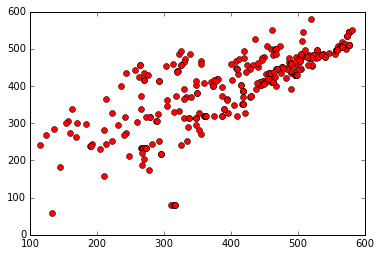

In [160]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

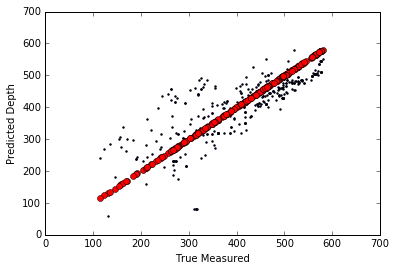

In [161]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [162]:
import pdvega
import vega

In [163]:
test_df_pred2

CALI     COND     DELT     DEPT   DPHI  DT  DistFrom_NN1_TopDepth       GR  GR_max_15winSize_dirabove  GR_max_15winSize_diraround  GR_max_1winSize_dirabove  GR_max_1winSize_diraround  GR_max_21winSize_dirabove  GR_max_21winSize_diraround  GR_max_3winSize_dirabove  GR_max_3winSize_diraround  GR_max_7winSize_dirabove  GR_max_7winSize_diraround  GR_mean_15winSize_dirabove  GR_mean_15winSize_diraround  GR_mean_1winSize_dirabove  GR_mean_1winSize_diraround  GR_mean_21winSize_dirabove  GR_mean_21winSize_diraround  GR_mean_3winSize_dirabove  GR_mean_3winSize_diraround  GR_mean_7winSize_dirabove  GR_mean_7winSize_diraround  GR_min_15winSize_dirabove  GR_min_15winSize_dirabove_n3  GR_min_15winSize_diraround  GR_min_15winSize_diraround_n3  GR_min_1winSize_dirabove  GR_min_1winSize_dirabove_n3  GR_min_1winSize_diraround  GR_min_1winSize_diraround_n3  GR_min_21winSize_dirabove  GR_min_21winSize_dirabove_n3  GR_min_21winSize_diraround  GR_min_21winSize_diraround_n3  \
101   194.650      NaN  360.524  461.114    NaN NaN                 80.216   80.469                     94.431                      94.431                    80.469                     80.469                     94.431                      94.431                    91.546                     85.083                    94.431                     94.431                   85.771867                    82.970133                     80.469                      80.469                   83.764905                    82.214905                  85.699333                   79.153667                  87.630714                   81.051000                     78.493                     93.096667                      68.963                      93.096667                    80.469                       80.469                     80.469                        80.469                     76.269                     93.096667                      68.963                      93.096667   
887   143.518      NaN      NaN  575.318  0.119 NaN                -44.058   22.150                     51.909                      51.909                    22.150                     22.150                     51.909                      51.909                    25.699                     23.477                    51.909                     29.281                   34.186400                    28.845333                     22.150                      22.150                   34.046238                    28.645286                  23.365667                   22.625000                  32.943714                   25.094000                     22.150                     46.248000                      17.160                      46.248000                    22.150                       22.150                     22.150                        22.150                     22.150                     46.248000                      17.063                      46.248000   
888   143.465      NaN      NaN  575.568  0.071 NaN                -44.308   23.477                     51.909                      51.909                    23.477                     23.477                     51.909                      51.909                    23.477                     25.513                    43.162                     27.290                   34.069800                    27.071333                     23.477                      23.477                   33.440762                    27.793619                  22.625000                   23.713333                  28.882000                   24.676000                     22.150                     46.248000                      17.063                      43.742667                    23.477                       23.477                     23.477                        23.477                     22.150                     46.248000                      17.063                      46.248000   
889   143.291      NaN      NaN  575.818  0.022 NaN                -44.558   25.513          

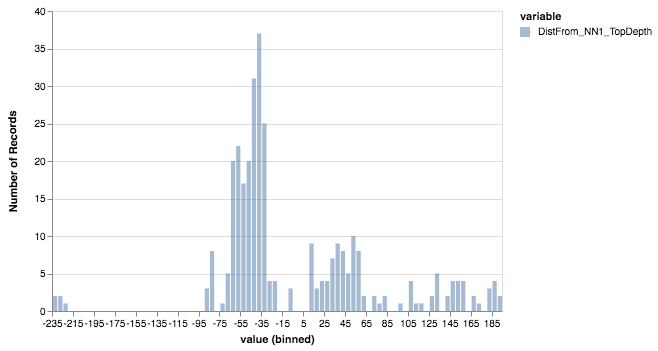

In [164]:
# 'MM_Top_Depth_predBy_NN1thick'
test_df_pred2_TopScratch2 = test_df_pred2[['DistFrom_NN1_TopDepth']]
test_df_pred2_TopScratch2.vgplot.hist(bins=100, alpha=0.5)

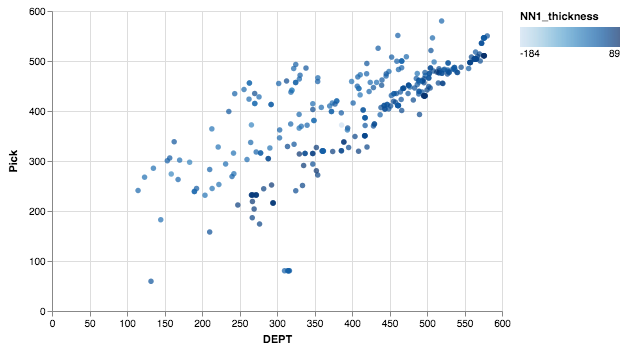

In [165]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='NN1_thickness')

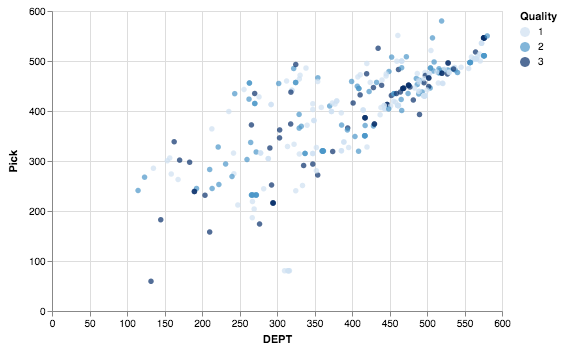

In [166]:
#c='McMurray_Base_DEPTH'
test_df_pred2.vgplot(kind='scatter', x='DEPT', y='Pick',c='Quality')